In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor

from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
from brewer2mpl import qualitative

from task import generate_trials, rule_name
from network import Model, get_perf
from analysis import performance
from analysis import standard_analysis
import tools

import numpy as np
from scipy import linalg as LA
import rcca
import datetime
from scipy.spatial import procrustes

In [3]:
def pca(x): # obs by variables
    #centering the data
    x -= np.mean(x, axis = 0)
    cov = np.cov(x, rowvar = False)
    evals , evecs = LA.eigh(cov)
    #sort the eigenvalues (and eigenvectors accordingly) descending
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    evals = evals[idx]
    return evecs, evals, x


def CCA_prep(X, n_components):
    evecs, evals, x = pca(X)
    a = np.dot(x,evecs[:,0:n_components])
    # Split each dataset into two halves: training set and test set for CCA
    nSamples = int(np.shape(a)[0]/2)
    train = a[0:nSamples,:]
    test = a[nSamples:2*nSamples,:]
    return train, test

def CCA_compute(train1, train2, n_components):
    # Create a cca object as an instantiation of the CCA object class. 
    #nComponents = 10
    cca = CCA(n_components=n_components)

    # Use the train() method to find a CCA mapping between the two training sets.
    cca.fit(train1, train2)
    return cca

def rCCA_compute(train1, train2, n_components):
    # Create a cca object as an instantiation of the CCA object class. 
    #nComponents = 10
    cca = rcca.CCA(kernelcca = False, reg = 0, numCC = n_components)

    # Use the train() method to find a CCA mapping between the two training sets.
    cca.train([train1, train2])
    return cca

def gen_trials_from_model_dir(model_dir):
    model = Model(model_dir)
    with tf.Session() as sess:
        model.restore()
        model.cell._sigma=0
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        # create a trial
        rule_train_now = hparams['rng'].choice(hparams['rule_trains'],p=hparams['rule_probs'])
        trial = generate_trials(rule_train_now, hparams, mode='random', noise_on=False, batch_size =500)
    return trial    

def load_X_from_model_dir(model_dir,trial):
    model = Model(model_dir)
    with tf.Session() as sess:
        model.restore()
        model.cell._sigma=0
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        w_out = params[2]
        oc = orthogonal_complement(w_out)
        hparams = model.hp
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        # run model
        h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        x = np.transpose(h_tf,(2,1,0))
        X = np.reshape(x,(x.shape[0],-1))
        oc_X = np.matmul(X.T, oc)
    return oc_X    #return orthogonal complement of hidden unit activity to ouput projection matrix

def orthogonal_complement(x, normalize=True, threshold=1e-15):
    """Compute orthogonal complement of a matrix

    this works along axis zero, i.e. rank == column rank,
    or number of rows > column rank
    otherwise orthogonal complement is empty

    TODO possibly: use normalize='top' or 'bottom'

    """
    x = np.asarray(x)
    r, c = x.shape
    if r < c:
        import warnings
        warnings.warn('fewer rows than columns', UserWarning)

    # we assume svd is ordered by decreasing singular value, o.w. need sort
    s, v, d = np.linalg.svd(x)
    rank = (v > threshold).sum()

    oc = s[:, rank:]

    if normalize:
        k_oc = oc.shape[1]
        oc = oc.dot(np.linalg.inv(oc[:k_oc, :]))
    return oc


In [6]:
#hp grid search
n_components = 20
n_models = 20

model_path = '/home/laura/data/multitask/train_all'
# model_path = '/home/laura/code/yangnet/training/data/sub_training/contextdm1'
model_n = 0
trial_model_dir = os.path.join(model_path, str(model_n))
trial = gen_trials_from_model_dir(trial_model_dir)
train_all = {}
test_all = {}

for model_n in range(0,n_models):      
    model_dir = os.path.join(model_path, str(model_n))
    X = load_X_from_model_dir(model_dir,trial)
    train_all[model_n], test_all[model_n] = CCA_prep(X,n_components)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(341, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 33) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(33,) dtype=float32_ref>


InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [5]:
# Initialize a cca object as an instantiation of the CCACrossValidate class.
n_components = 20
ccaCV = rcca.CCACrossValidate(kernelcca=False, numCCs = range(3,n_components), regs = [0., 1e2, 1e4, 1e6])

train_set = train_all[0]
test_set = test_all[0]
for x in range(1,20):
    train_set = np.concatenate((train_set,train_all[x]))
    test_set = np.concatenate((test_set,test_all[x]))
    

# Use the train() and validate() methods to run the analysis and perform cross-dataset prediction.
ccaCV.train(train_set)
#     [train_all[0],train_all[1],train_all[2],train_all[3],train_all[4],train_all[5],
#            train_all[6],train_all[7],train_all[8],train_all[9],train_all[10],train_all[11],
#            train_all[12],train_all[13],train_all[14],train_all[15],train_all[16],train_all[17],
#            train_all[18],train_all[19]])
testcorrsCV = ccaCV.validate(test_set)
#([test_all[0],test_all[1],test_all[2],test_all[3],test_all[4],test_all[5],
#            test_all[6],test_all[7],test_all[8],test_all[9],test_all[10],test_all[11],
#            test_all[12],test_all[13],test_all[14],test_all[15],test_all[16],test_all[17],
#            test_all[18],test_all[19]])
# ccaCV.compute_ev([test_all[0],test_all[1],test_all[2],test_all[3],test_all[4],test_all[5]])

NameError: name 'train_all' is not defined

In [17]:
ccaCV.compute_ev([test_all[0],test_all[1],test_all[2],test_all[3],test_all[4],test_all[5]])

Computing explained variance for component #1
Computing explained variance for component #2
Computing explained variance for component #3
Computing explained variance for component #4
Computing explained variance for component #5
Computing explained variance for component #6
Computing explained variance for component #7
Computing explained variance for component #8
Computing explained variance for component #9
Computing explained variance for component #10
Computing explained variance for component #11
Computing explained variance for component #12
Computing explained variance for component #13
Computing explained variance for component #14
Computing explained variance for component #15
Computing explained variance for component #16
Computing explained variance for component #17


[array([[3.65627727e-01, 4.07166656e-01, 2.93992219e-01, 2.60512434e-01,
         3.88356697e-01, 4.66013895e-01, 3.37159378e-01, 5.67020409e-01,
         6.33557685e-01, 6.02000001e-01, 3.41542904e-01, 7.38614056e-02,
         1.58643823e-01, 6.84182998e-02, 8.32962138e-01, 1.20998774e+00,
         1.68793600e+00, 1.31785828e+00, 2.03929629e+00, 1.66301640e+00],
        [3.65940061e-01, 4.12219408e-01, 3.10064305e-01, 2.88702362e-01,
         3.89760942e-01, 4.91217389e-01, 3.92622731e-01, 4.23852946e-01,
         6.59938316e-01, 3.95972164e-01, 3.42456539e-01, 2.31565600e-01,
         1.45265511e-01, 2.51699947e-01, 4.33593839e-01, 1.07541796e+00,
         2.10347974e+00, 1.03522329e+00, 1.68913744e+00, 1.02549524e+00],
        [3.66334844e-01, 4.12747056e-01, 2.89624543e-01, 2.70141729e-01,
         4.00601100e-01, 5.09346517e-01, 2.65967486e-01, 2.54354614e-01,
         6.30979511e-01, 4.83094135e-01, 2.62969621e-01, 8.90302487e-02,
         2.77605962e-03, 7.04195317e-01, 7.782713

In [26]:
print(ccaCV.best_numCC, ccaCV.best_reg)

# """Returns:
#         ws (list): canonical weights
#         comps (list): canonical components
#         cancorrs (list): correlations of the canonical components
#                          on the training dataset
#         corrs (list): correlations on the validation dataset
#         preds (list): predictions on the validation dataset
#         ev (list): explained variance for each canonical dimension
#     """

print('ws', np.shape(ccaCV.ws))
print('comps', np.shape(ccaCV.comps))
print('cancorrs', np.shape(ccaCV.cancorrs))
print('corrs',np.shape(ccaCV.corrs))
print('preds',np.shape(ccaCV.preds))
print(np.shape(test_all[0]))
print('ev',np.shape(ccaCV.ev))
print(np.shape(ccaCV.preds[0]))
print(np.shape(trial.x))

fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT),tight_layout=True)
plt.plot(ccaCV.ev[0].T)

17 1000000.0
ws (20, 20, 17)
comps (20, 25000, 17)
cancorrs (17, 20, 20)
corrs (20, 20)
preds (20, 25000, 20)
(25000, 20)


AttributeError: 'CCACrossValidate' object has no attribute 'ev'

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


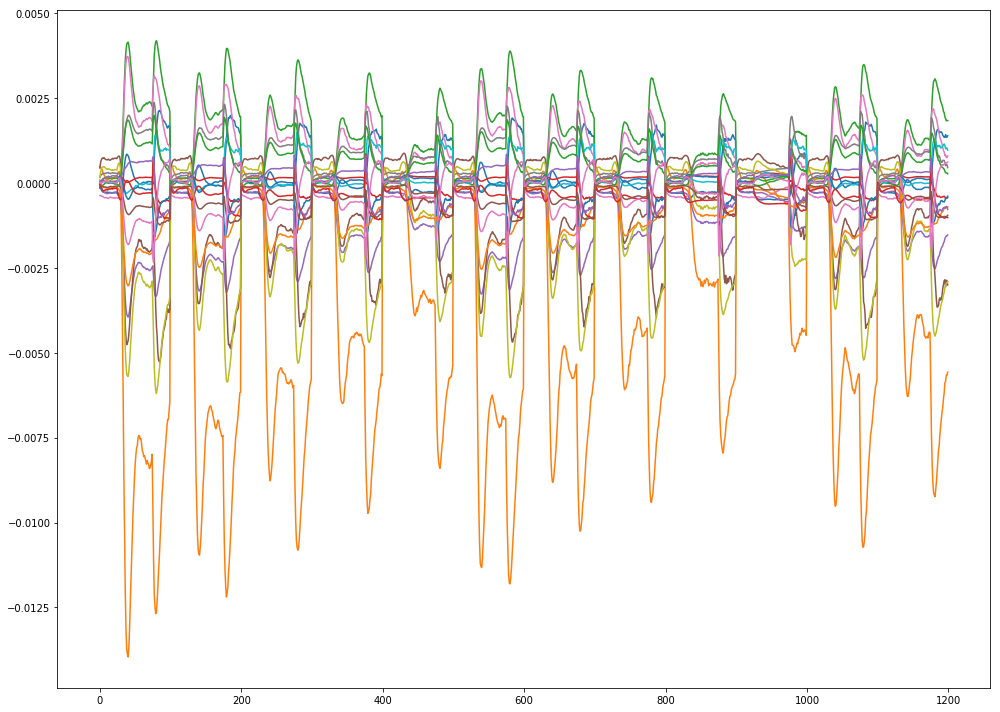

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


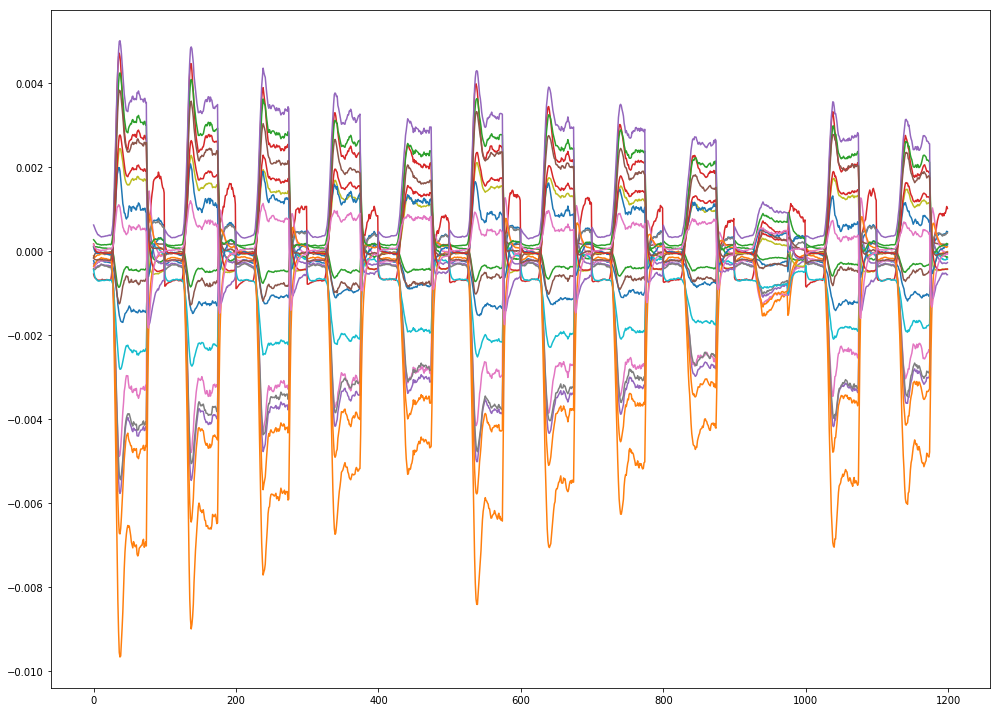

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


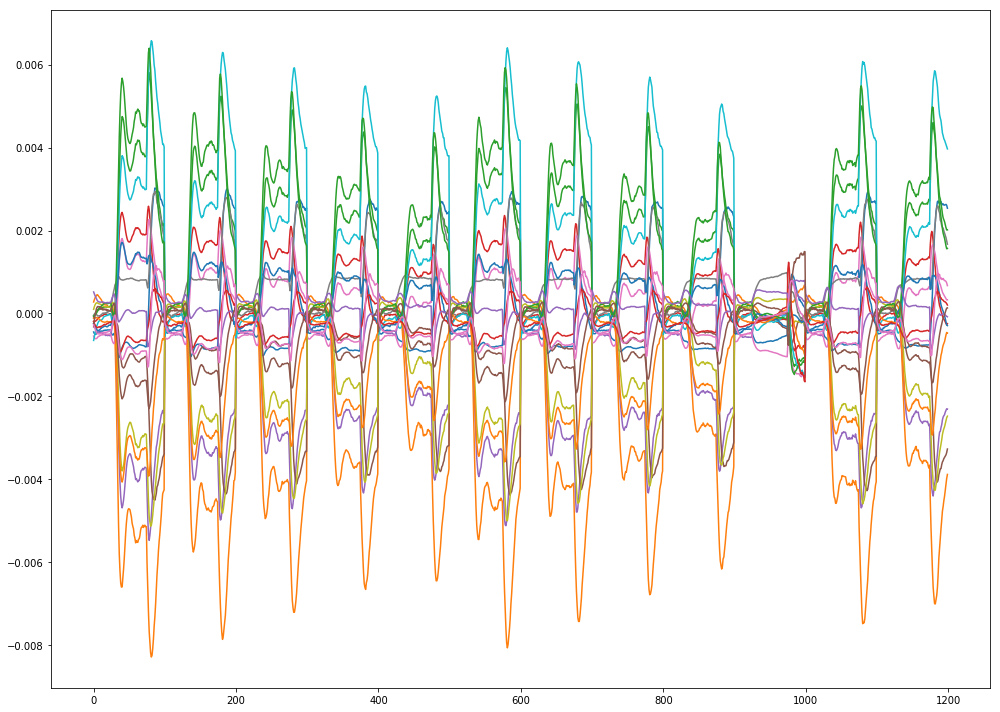

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


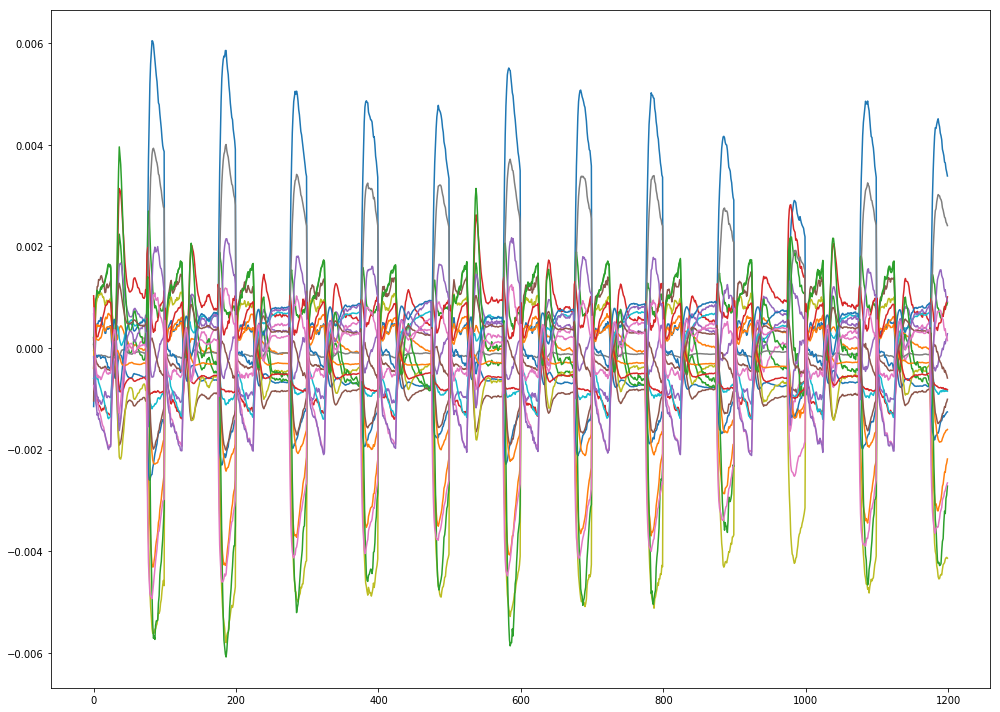

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


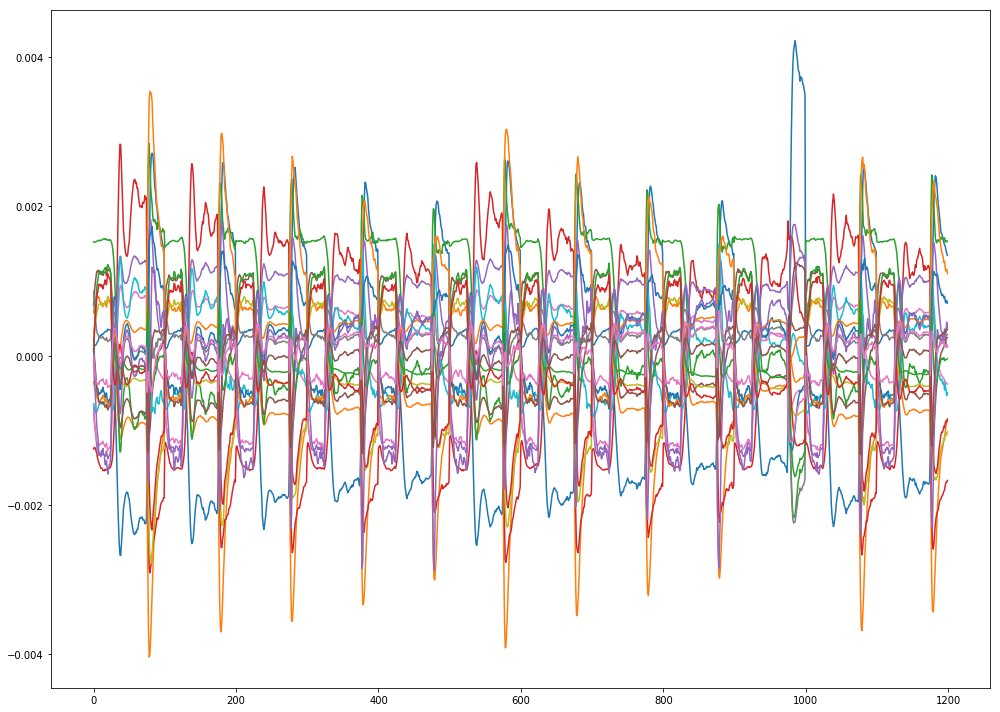

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


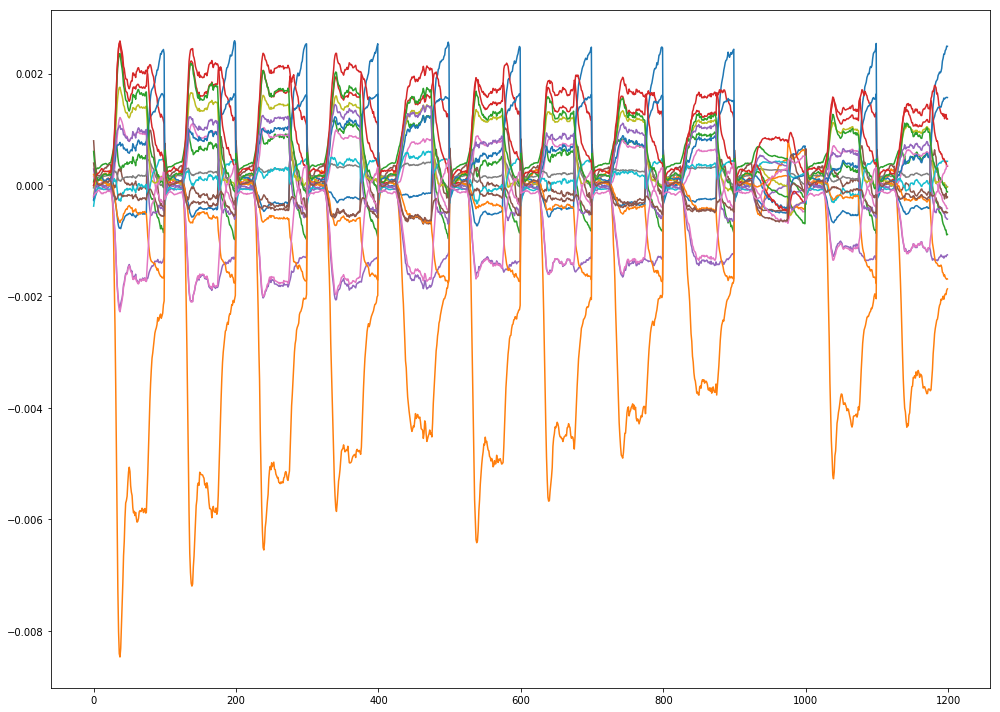

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


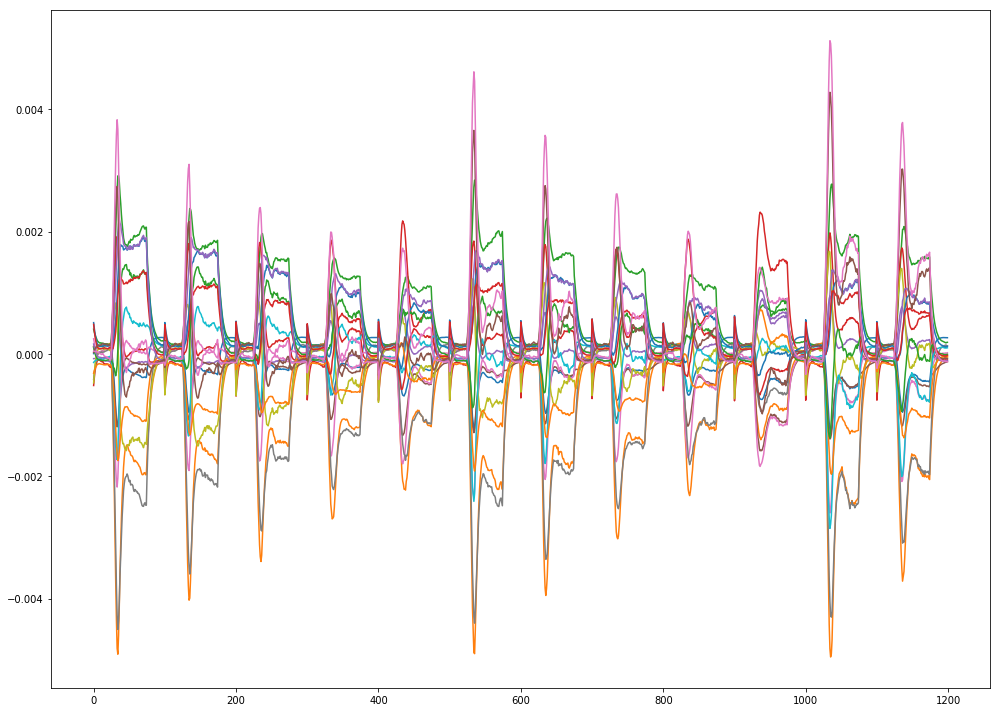

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


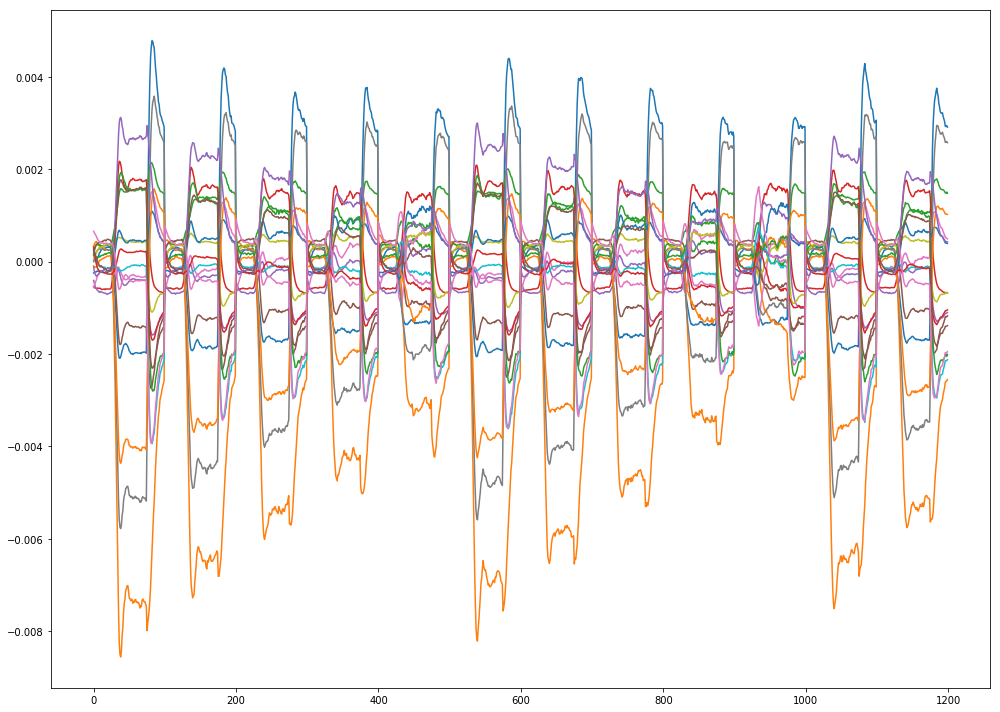

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


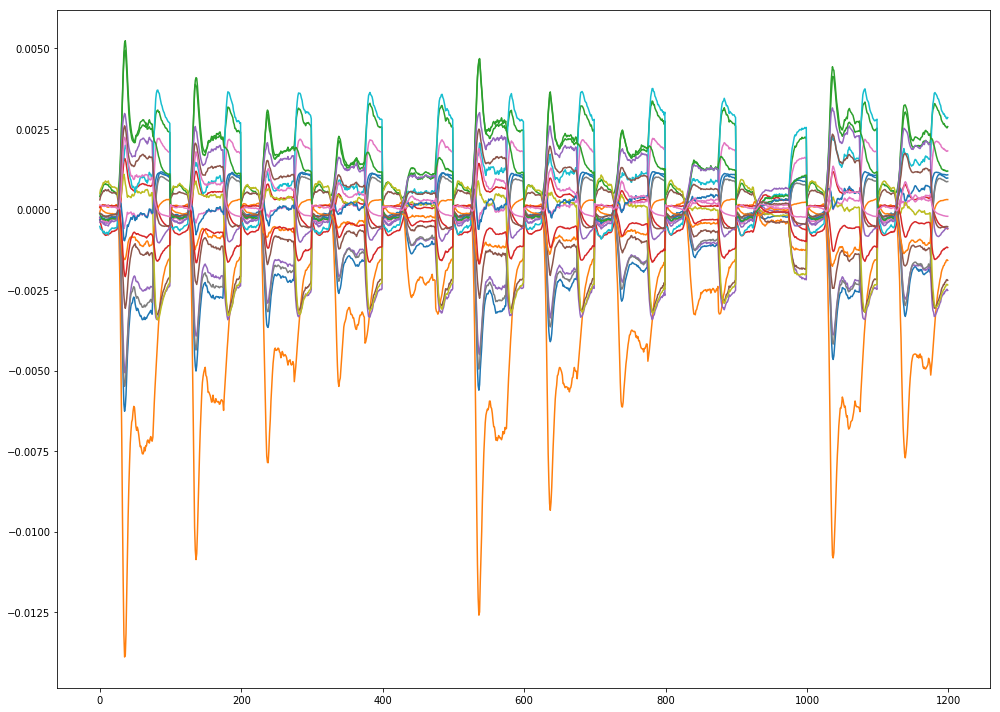

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


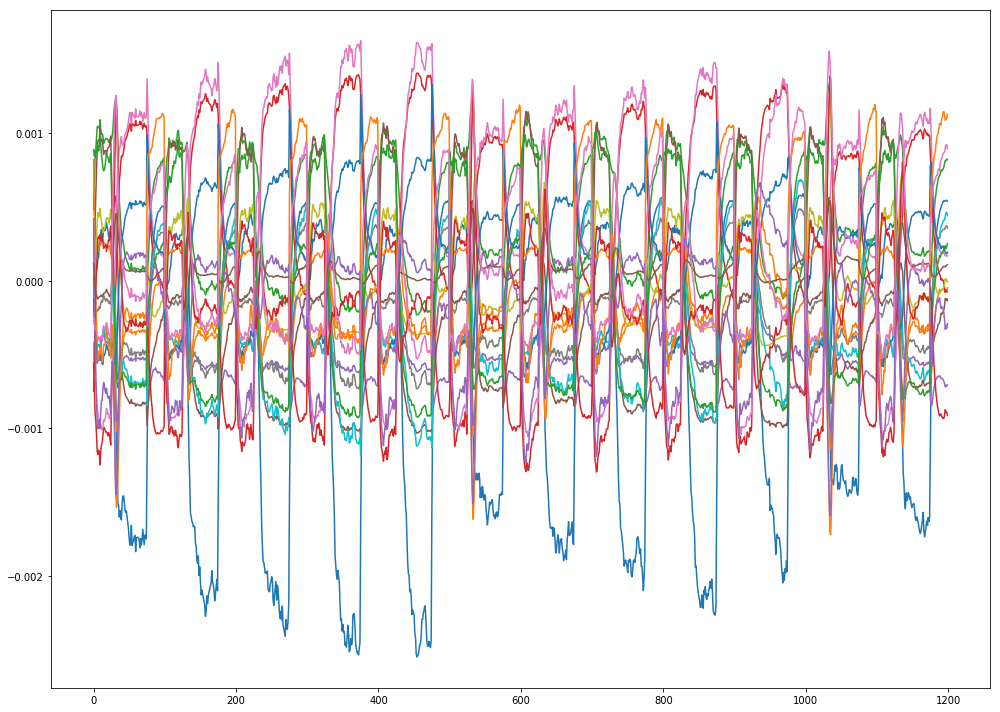

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


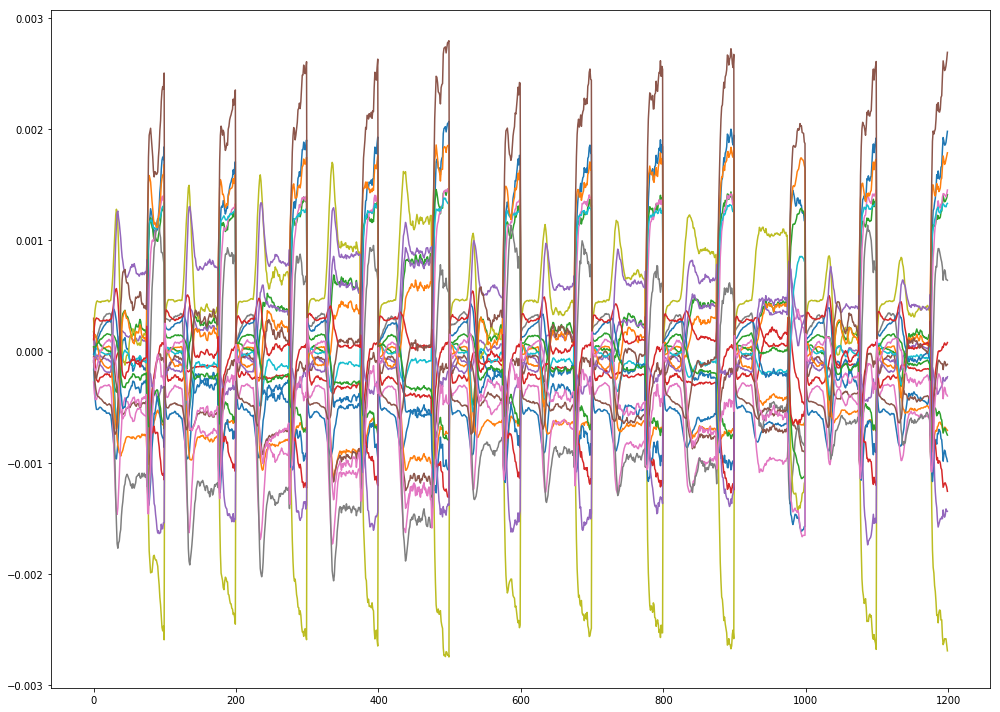

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


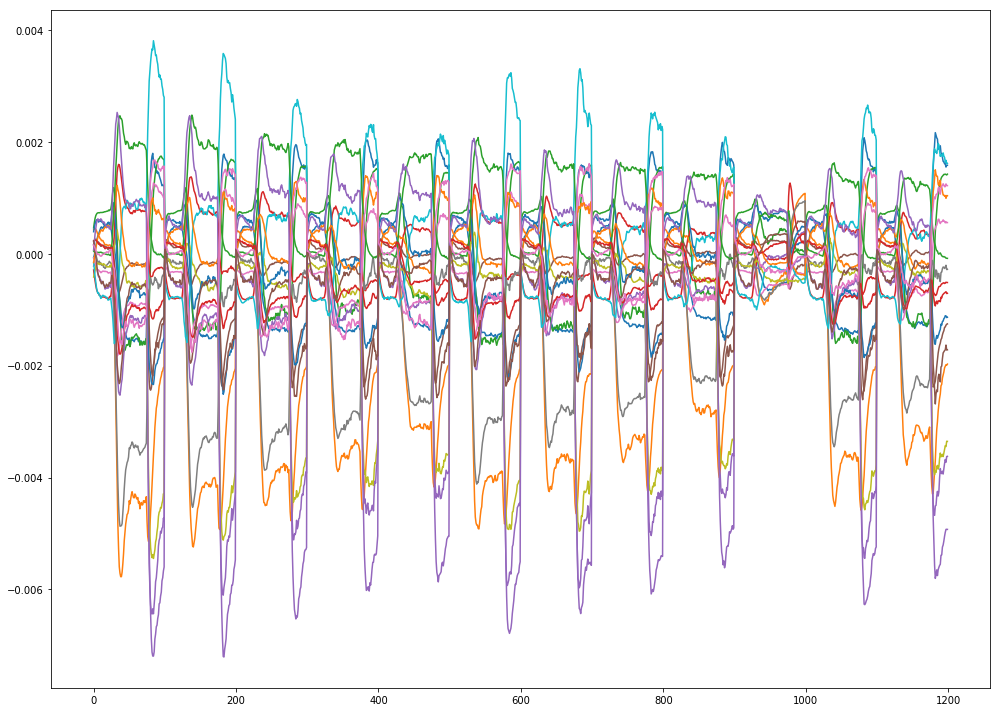

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


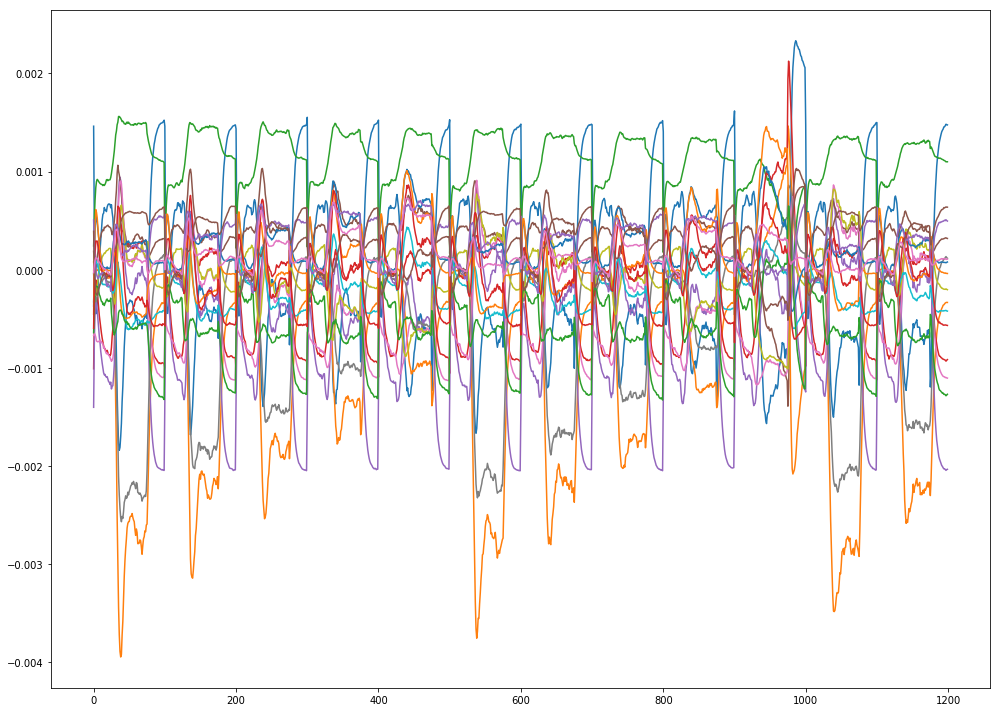

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


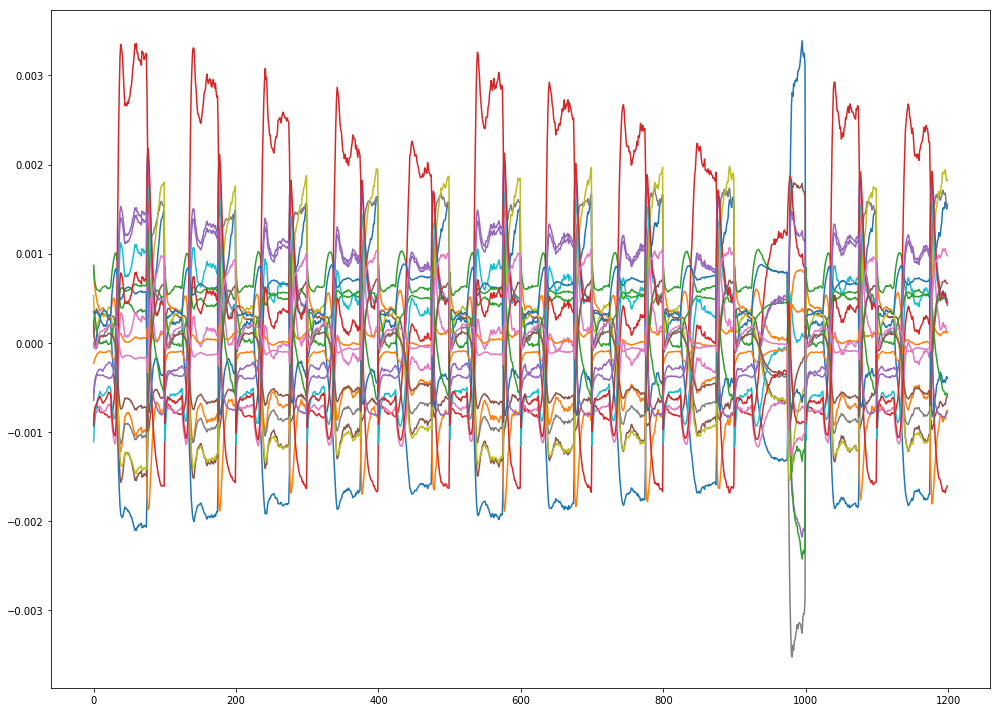

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


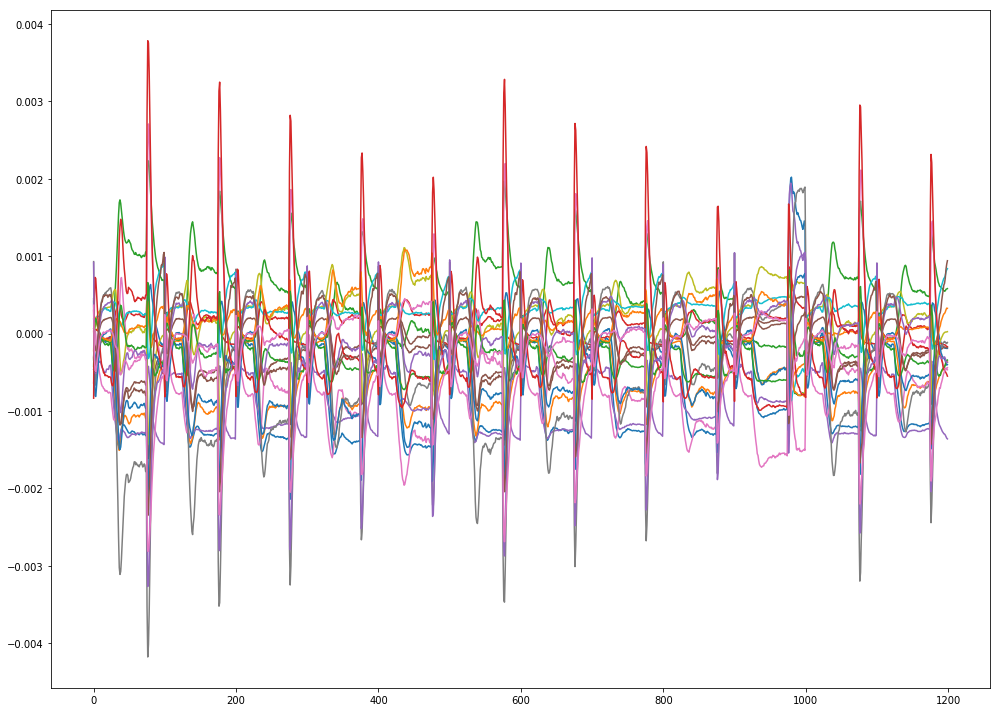

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


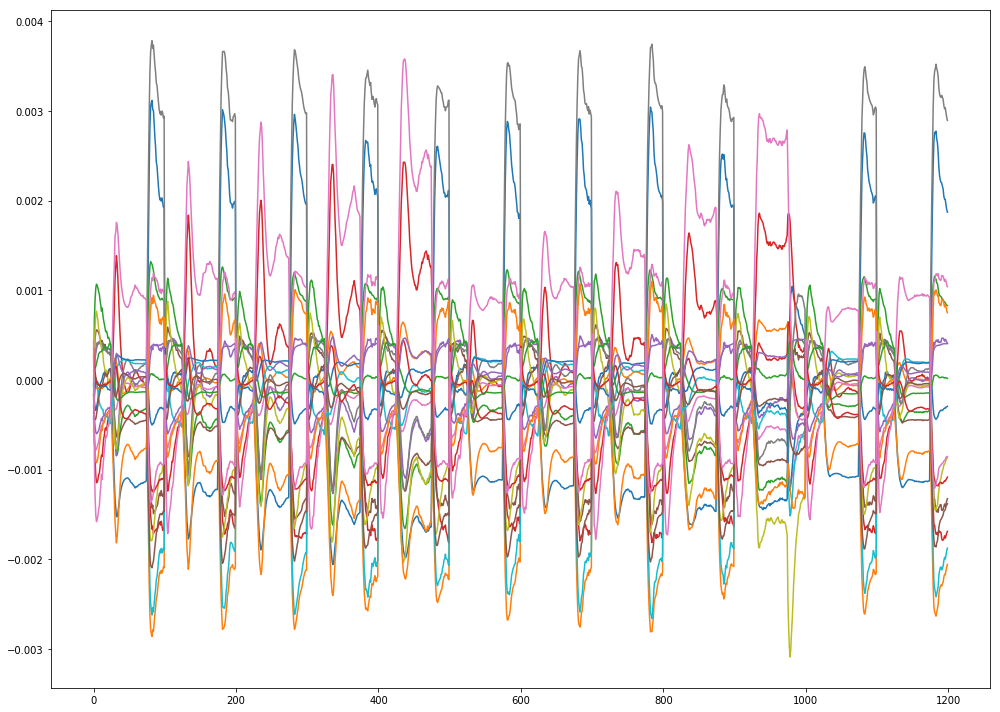

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


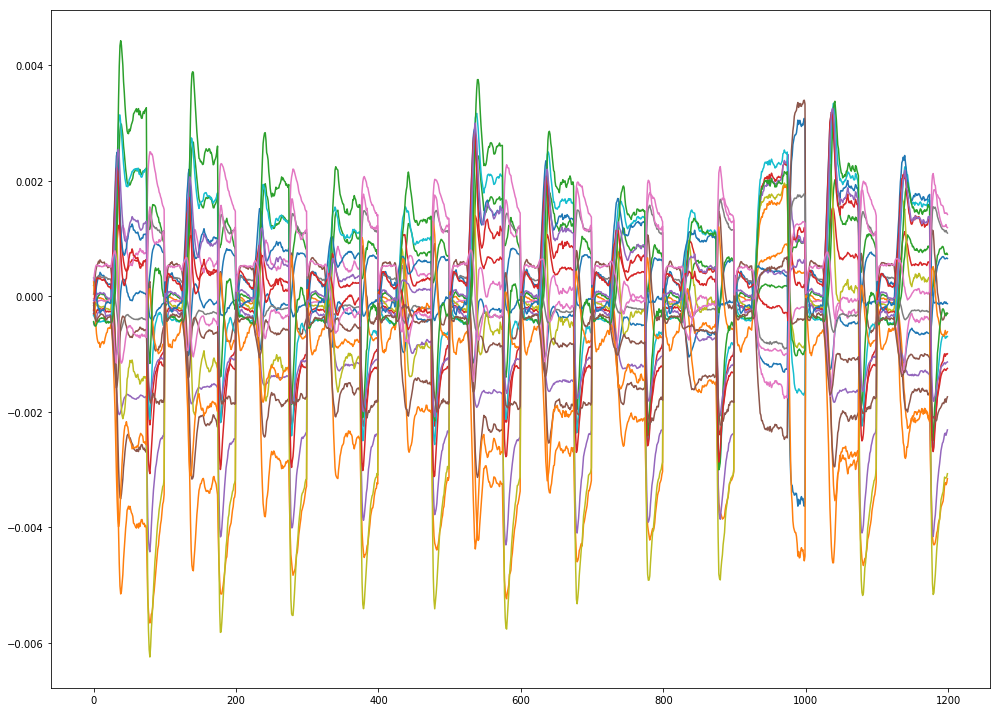

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


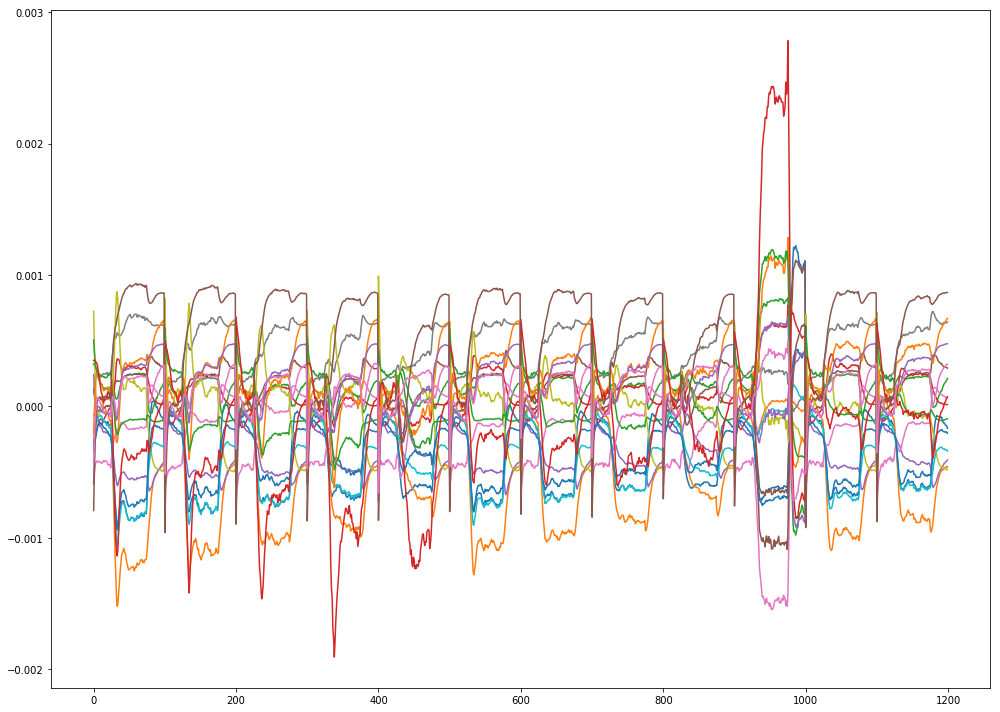

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


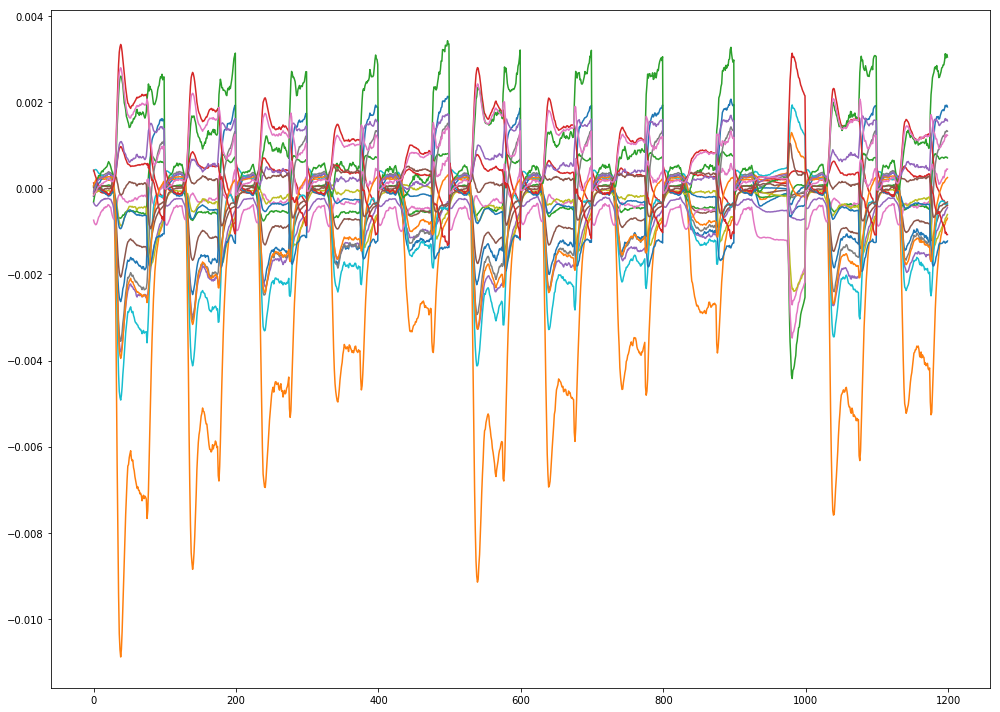

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


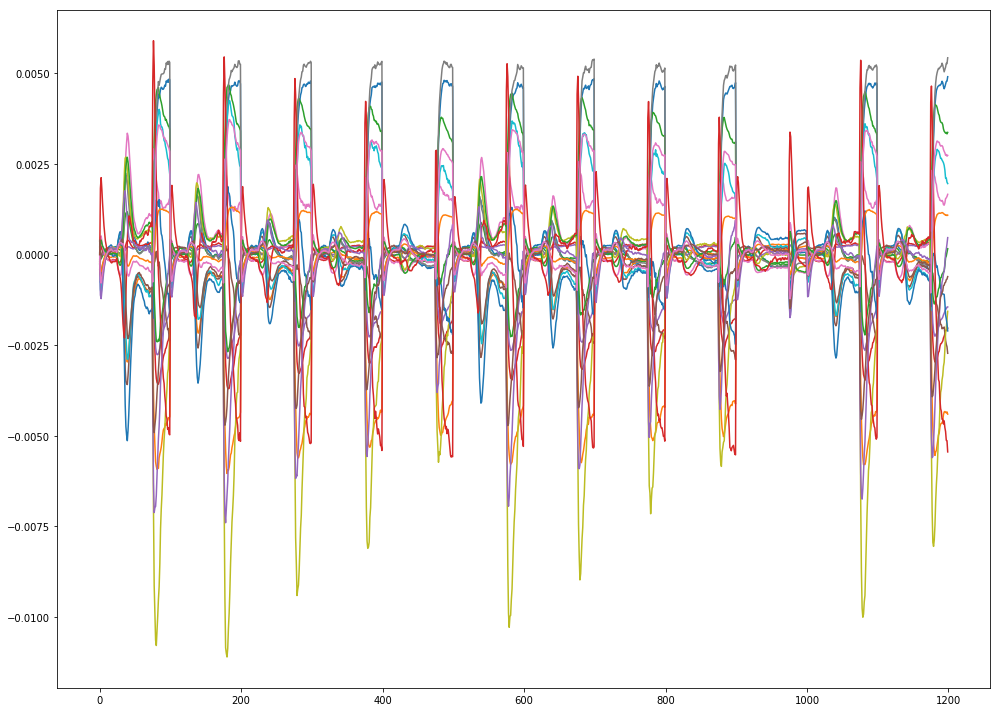

In [28]:
# Plot canonical correlations (cca.cancorrs)
# plt.plot(ccaCV.preds[0][0:2000,2])
# plt.plot(test_all[0][0:2000,2])
FIG_WIDTH = 14 # inches
FIG_HEIGHT = 10 # inches
FONT_WEIGHT = 'bold'

for model_n in range(0,n_models):
    fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT),tight_layout=True)
    plt.plot(ccaCV.comps[model_n][0:1200,:])


In [25]:
n_components = 10
n_models = 1
X = {}

channel_set = {'mod1':range(1,64),'mod2':range(33,64),'task_in':range(65,84)};
model_path = '/home/laura/code/yangnet/training/data/sub_training'
# task_names = ['1_6','pro','anti','reactgo_reactanti','reactgo']
task_names = os.listdir(model_path)
task_names = task_names[:13] + task_names[15:]

model_n = 0
task_n = 0
model_dir = os.path.join(model_path, task_names[task_n], str(model_n))
trial = gen_trials_from_model_dir(model_dir)
    
testcorrs = np.zeros((n_models,len(task_names),len(task_names)))
cancorrs = np.zeros((n_models,len(task_names),len(task_names),n_components))
for model_n in range(0,n_models):
	for task_num in range(len(task_names)):	        
	        model_dir = os.path.join(model_path, task_names[task_num], str(model_n))
	        print(model_dir)
	        X[task_names[task_num]] = load_X_from_model_dir(model_dir,trial)

	for task_num1 in range(len(task_names)):
		for task_num2 in range(len(task_names)):
			train0, test0 = CCA_prep(np.squeeze(X[task_names[task_num1]]))
			train1, test1 = CCA_prep(np.squeeze(X[task_names[task_num2]]))
			cca01 = rCCA_compute(train0, train1)
			cancorrs[model_n,task_num1,task_num2,:] = cca01.cancorrs

INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/dmsnogo/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/dmsnogo/0/model.ckpt
/home/laura/code/yangnet/training/data/sub_training/dmsnogo/0
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/dmsnogo/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/dmsnogo/0/model.ckpt
/home/laura/code/yangnet/training/data/sub_training/multidm/0
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/multidm/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/multidm/0/model.ckpt
/home/laura/code/yangnet/training/data/sub_training/contextdm2/0
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdm2/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/

Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.

Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.

Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.

Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.

Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.

Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components
Training CCA, kernel = None, regularization = 0.0000, 10 components


In [26]:
filename = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = os.path.join('/home/laura/data/multitask/analysis_data','cca')

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
np.save(os.path.join(save_dir,filename),cancorrs)

In [30]:
print(task_names)

['dmsnogo', 'multidm', 'contextdm2', 'contextdelaydm1', 'delayanti', 'contextdelaydm2', 'contextdm1', 'reactgo_reactanti', 'fdgo_fdanti', 'pro', 'dm1', 'dmcgo', 'dm2', 'reactanti', 'delaygo', 'multidelaydm', 'fdanti', 'fdgo', 'delaygo_delayanti', 'contextdm1_contextdm2', 'reactgo', 'delaydm1', 'anti', '1_6', 'dmsgo']


contextdm2


/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


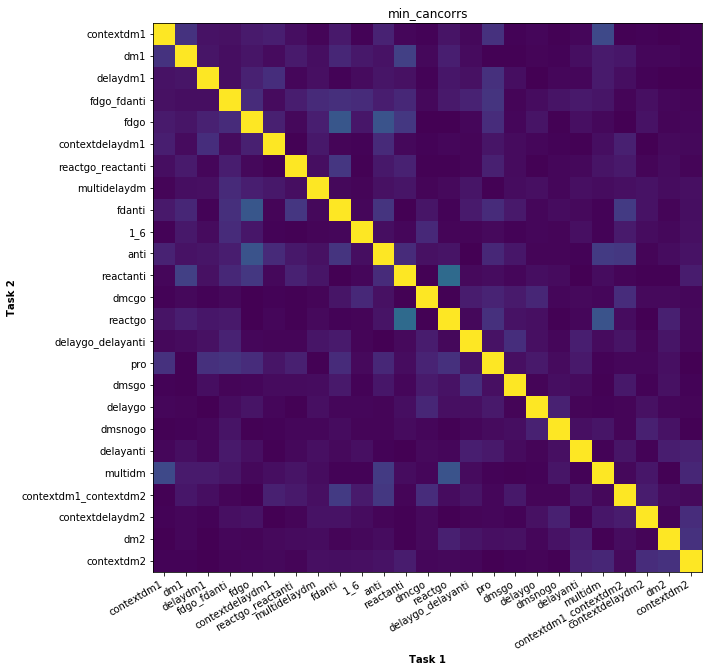

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


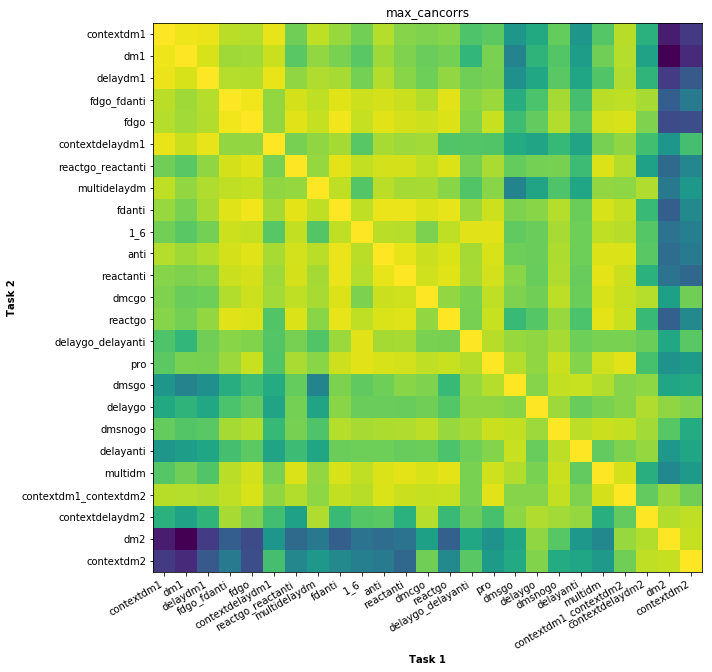

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


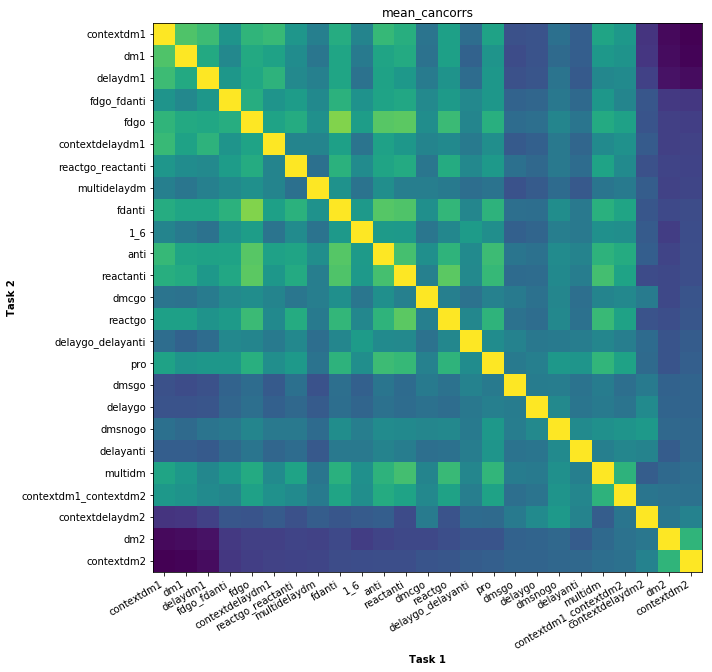

In [31]:
task_sort_ind = 2 #change this
print(task_names[task_sort_ind])

mean_vec = np.nanmean(np.nanmean(cancorrs,axis = 3),axis = 0)
s = np.argsort(mean_vec[task_sort_ind,:])
cancorrs_sorted = cancorrs[:,:,s,:]
cancorrs_sorted = cancorrs_sorted[:,s,:,:]
task_names_sorted = []
for sind in range(0,len(s)):
	task_names_sorted.append(task_names[s[sind]])

mean_cancorrs = np.nanmean(cancorrs_sorted,axis=0)
min_cancorrs = np.min(mean_cancorrs, axis=2) 
max_cancorrs = np.max(mean_cancorrs, axis=2) 
mean_cancorrs = np.mean(mean_cancorrs, axis=2) 
title_set = ['min_cancorrs','max_cancorrs','mean_cancorrs']

for corrmat, ttl in zip([min_cancorrs,max_cancorrs,mean_cancorrs], title_set):
    FIG_WIDTH = 10 # inches
    FIG_HEIGHT = 10 # inches
    FONT_WEIGHT = 'bold'
    fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT),tight_layout=True)
    ax = fig.add_subplot(111)
    ax.set_xlabel('Task 1', fontweight=FONT_WEIGHT)
    ax.set_ylabel('Task 2', fontweight=FONT_WEIGHT)
    ax.imshow(corrmat)
    ax.set_xticks(range(0,len(task_names)))
    ax.set_yticks(range(0,len(task_names)))
    ax.set_yticklabels(task_names_sorted)
    fig.autofmt_xdate()
    ax.set_xticklabels(task_names_sorted)
    ax.set_title(ttl)

In [32]:
s = np.argsort(np.squeeze(cancorrs[0,5,:,3]))
cancorrs_sorted = cancorrs[:,:,s,:]
cancorrs_sorted = cancorrs_sorted[:,s,:,:]
task_names_sorted = []
for sind in range(0,len(s)):
	task_names_sorted.append(task_names[s[sind]])

single_model = 2 #change this
mean_cancorrs = cancorrs_sorted[single_model,:,:,:]
min_cancorrs = np.min(mean_cancorrs, axis=2) 
max_cancorrs = np.max(mean_cancorrs, axis=2) 
mean_cancorrs = np.mean(mean_cancorrs, axis=2) 
title_set = ['min_cancorrs','max_cancorrs','mean_cancorrs']

for corrmat, ttl in zip([min_cancorrs,max_cancorrs,mean_cancorrs], title_set):
    FIG_WIDTH = 10 # inches
    FIG_HEIGHT = 10 # inches
    FONT_WEIGHT = 'bold'
    fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT),tight_layout=True)
    ax = fig.add_subplot(111)
    ax.set_xlabel('Task 1', fontweight=FONT_WEIGHT)
    ax.set_ylabel('Task 2', fontweight=FONT_WEIGHT)
    ax.imshow(corrmat)
    ax.set_xticks(range(0,len(task_names)))
    ax.set_yticks(range(0,len(task_names)))
    ax.set_yticklabels(task_names_sorted)
    fig.autofmt_xdate()
    ax.set_xticklabels(task_names_sorted)
    ax.set_title(ttl)

IndexError: index 2 is out of bounds for axis 0 with size 1

In [ ]:
fig = plt.figure(figsize=(20, 20),tight_layout=True)
for model in range(0,n_models):
	for component in range(0, n_components):
		ax = plt.subplot(n_models, n_components, n_components*model+component+1)
		ax.set_xlabel('Task 1', fontweight=FONT_WEIGHT)
		ax.set_ylabel('Task 2', fontweight=FONT_WEIGHT)
        
		ax.imshow(np.squeeze(cancorrs_sorted[model,:,:,component]))
# 		ax.set_xticks(range(0,len(task_names)))
# 		ax.set_yticks(range(0,len(task_names)))
# 		ax.set_yticklabels(task_names_sorted)
# 		fig.autofmt_xdate()
# 		ax.set_xticklabels(task_names_sorted)
		ax.set_title('model ' + str(model) + ' component ' + str(component))


In [29]:
# Subsets of trial types
n_components = 17
n_models = 3
X = {}
model_path = '/home/laura/code/yangnet/training/data/sub_training'
task_names = ['contextdm1','contextdm2','contextdm1_contextdm2']

model_n = 0
trial_dir0 = os.path.join(model_path, task_names[0], str(model_n))
trial_dir1 = os.path.join(model_path, task_names[1], str(model_n))
trial0 = gen_trials_from_model_dir(trial_dir0)
trial1 = gen_trials_from_model_dir(trial_dir1)
    
cancorrs = np.zeros((15,2,len(task_names),len(task_names),n_components))
testcorrs = np.zeros((15,2,len(task_names),len(task_names),2*n_components))
n = -1
for m0 in range(0,n_models):
    for m1 in range(m0+1,n_models):
        n=n+1
    
        for task_trial in range(0,2):
            trial_dir = os.path.join(model_path, task_names[task_trial], str(0))
            trial = gen_trials_from_model_dir(trial_dir)
            
            for task_num1 in range(len(task_names)):
                for task_num2 in range(len(task_names)):
                    model_dir0 = os.path.join(model_path, task_names[task_num1], str(m0))
                    model_dir1 = os.path.join(model_path, task_names[task_num2], str(m1))                    

                    X0 = load_X_from_model_dir(model_dir0,trial)
                    X1 = load_X_from_model_dir(model_dir1,trial)

                    train0, test0 = CCA_prep(X0,n_components)
                    train1, test1 = CCA_prep(X1,n_components)
                    cca01 = rCCA_compute(train0, train1, n_components)
                    
                    testcorrs[n,task_trial,task_num1,task_num2,0:n_components] = cca01.validate([test0, test1])[0]
                    
                    testcorrs[n,task_trial,task_num1,task_num2,n_components:] = cca01.validate([test0, test1])[1]
                    
                    cancorrs[n,task_trial,task_num1,task_num2,:] = cca01.cancorrs


INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdm1/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/contextdm1/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdm2/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/contextdm2/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdm1/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/contextdm1/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdm1/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/contextdm1/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdm1/1/model.ckpt
Mo

INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdm2/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/contextdm2/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdm1_contextdm2/1/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/contextdm1_contextdm2/1/model.ckpt
Training CCA, kernel = None, regularization = 10000.0000, 17 components
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdm1_contextdm2/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/contextdm1_contextdm2/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdm1/1/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/contextdm1/1/model.ckpt
Trai

Training CCA, kernel = None, regularization = 10000.0000, 17 components
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdm1/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/contextdm1/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdm1_contextdm2/2/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/contextdm1_contextdm2/2/model.ckpt
Training CCA, kernel = None, regularization = 10000.0000, 17 components
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdm2/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/contextdm2/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdm1/2/model.ckpt
Model restored from file: /home/laura/code/yangnet/train

Model restored from file: /home/laura/code/yangnet/training/data/sub_training/contextdm1_contextdm2/1/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdm1_contextdm2/2/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/contextdm1_contextdm2/2/model.ckpt
Training CCA, kernel = None, regularization = 10000.0000, 17 components
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdm2/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/contextdm2/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdm1/1/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/contextdm1/1/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdm1/2/model.ckpt
Model restored 

In [30]:
print(cca01.validate([test0, test1])[0],n)

[0.79273502 0.70661663 0.67502636 0.74416795 0.59286715 0.53161496
 0.56176652 0.6116101  0.53142093 0.79900763 0.67349682 0.64436129
 0.83101294 0.78251669 0.56741146 0.23770357 0.39175192] 2


In [31]:
mean_xcomponents_val = np.nanmean(testcorrs[0:n,:,:,:,:],axis=4)
mean_xmodels_val = np.nanmean(mean_xcomponents_val,axis=0)

mean_xcomponents = np.nanmean(cancorrs[0:n,:,:,:,:],axis=4)
mean_xmodels = np.nanmean(mean_xcomponents,axis=0)
title_set = task_names
print(testcorrs.shape)

(15, 2, 3, 3, 34)


/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


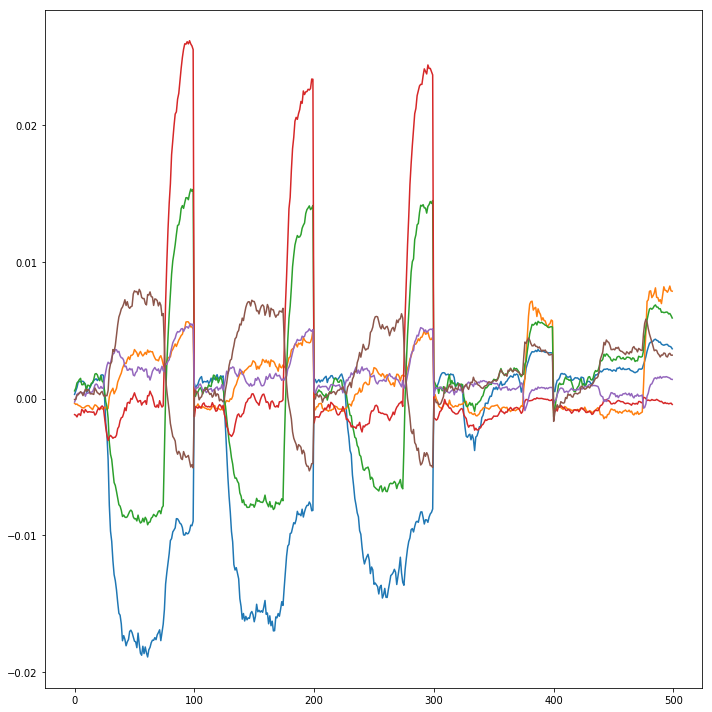

In [32]:
FIG_WIDTH = 10 # inches
FIG_HEIGHT = 10 # inches
FONT_WEIGHT = 'bold'
fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT),tight_layout=True)
plt.plot(cca01.comps[0][0:500,0:6])

IndexError: index 2 is out of bounds for axis 0 with size 2

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


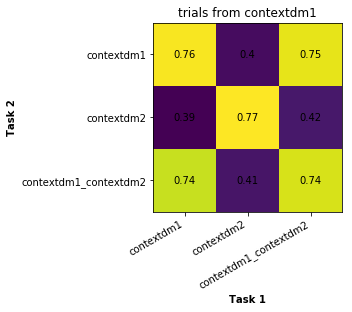

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


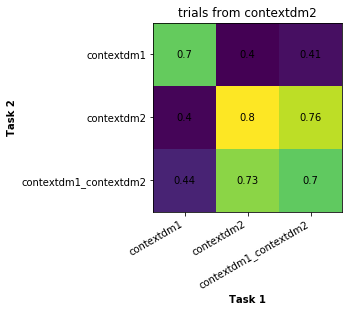

In [33]:
for trial, ttl in zip(range(0,3), title_set):
    corrmat = np.squeeze(mean_xmodels[trial,:,:])
    FIG_WIDTH = 5 # inches
    FIG_HEIGHT = 5 # inches
    FONT_WEIGHT = 'bold'
    fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT),tight_layout=True)
    ax = fig.add_subplot(111)
    ax.set_xlabel('Task 1', fontweight=FONT_WEIGHT)
    ax.set_ylabel('Task 2', fontweight=FONT_WEIGHT)
    ax.imshow(corrmat)
    ax.set_xticks(range(0,len(task_names)))
    ax.set_yticks(range(0,len(task_names)))
    ax.set_yticklabels(task_names)
    fig.autofmt_xdate()
    ax.set_xticklabels(task_names)
    ax.set_title('trials from ' + ttl)
    for (j,i),label in np.ndenumerate(corrmat):
        ax.text(i,j,round(label,2),ha='center',va='center')

In [30]:
# Subsets of trial types
n_components = 20
n_models = 6
X = {}
model_path_single = '/home/laura/code/yangnet/training/data/sub_training'
model_path_all = '/home/laura/data/multitask/train_all'
task_names = ['fdgo', 'reactgo', 'fdanti', 'reactanti', 'delayanti','delaygo',
              'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo']
    
n_comparisons = int((n_models*(n_models-1))/2)    
cancorrs_aa = np.zeros((n_comparisons,len(task_names)))
cancorrs_as = np.zeros((n_comparisons,len(task_names)))
cancorrs_ss = np.zeros((n_comparisons,len(task_names)))
n = -1
for m0 in range(0,n_models):
    model_dir0a = os.path.join(model_path_all, str(m0))  
    
    for m1 in range(m0+1,n_models):
        n += 1
        model_dir1a = os.path.join(model_path_all, str(m1))
    
        for task_trial in range(0,len(task_names)):
            trial_dir = os.path.join(model_path_single, task_names[task_trial], str(0))
            trial = gen_trials_from_model_dir(trial_dir)
                              
            model_dir0s = os.path.join(model_path_single, task_names[task_trial], str(m0))
            model_dir1s = os.path.join(model_path_single, task_names[task_trial], str(m1))

            X0s = load_X_from_model_dir(model_dir0s,trial)
            X1s = load_X_from_model_dir(model_dir1s,trial)
            train0s, test0s = CCA_prep(X0s,n_components)
            train1s, test1s = CCA_prep(X1s,n_components)
            
            X0a = load_X_from_model_dir(model_dir0a,trial)
            X1a = load_X_from_model_dir(model_dir1a,trial)
            train0a, test0a = CCA_prep(X0a,n_components)
            train1a, test1a = CCA_prep(X1a,n_components)
            
            cca_aa = rCCA_compute(train0a, train1a, n_components)
            cca_as = rCCA_compute(train0a, train1s, n_components)
            cca_ss = rCCA_compute(train0s, train1s, n_components)

            cancorrs_aa[n,task_trial] = np.mean(cca_aa.cancorrs)
            cancorrs_as[n,task_trial] = np.mean(cca_as.cancorrs)
            cancorrs_ss[n,task_trial] = np.mean(cca_ss.cancorrs)

INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/fdgo/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/fdgo/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/fdgo/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/fdgo/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/fdgo/1/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/fdgo/1/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/0/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/1/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/1/model.ckpt
Training CCA, kernel = None, regularizat

INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/dm2/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/dm2/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/dm2/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/dm2/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/dm2/1/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/dm2/1/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/0/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/1/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/1/model.ckpt
Training CCA, kernel = None, regularization = 

INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdelaydm2/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/contextdelaydm2/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdelaydm2/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/contextdelaydm2/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdelaydm2/1/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/contextdelaydm2/1/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/0/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/1/model.ckpt
Model restored from file: /home/laura/data/multita

INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/reactanti/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/reactanti/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/reactanti/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/reactanti/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/reactanti/2/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/reactanti/2/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/0/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/2/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/2/model.ckpt
Training C

INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/multidm/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/multidm/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/multidm/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/multidm/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/multidm/2/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/multidm/2/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/0/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/2/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/2/model.ckpt
Training CCA, kernel =

Training CCA, kernel = None, regularization = 0.0000, 20 components
Training CCA, kernel = None, regularization = 0.0000, 20 components
Training CCA, kernel = None, regularization = 0.0000, 20 components
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/dmsnogo/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/dmsnogo/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/dmsnogo/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/dmsnogo/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/dmsnogo/2/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/dmsnogo/2/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/0/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all

Model restored from file: /home/laura/data/multitask/train_all/3/model.ckpt
Training CCA, kernel = None, regularization = 0.0000, 20 components
Training CCA, kernel = None, regularization = 0.0000, 20 components
Training CCA, kernel = None, regularization = 0.0000, 20 components
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/dm1/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/dm1/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/dm1/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/dm1/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/dm1/3/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/dm1/3/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/0/model.ckpt
Model rest

Model restored from file: /home/laura/data/multitask/train_all/3/model.ckpt
Training CCA, kernel = None, regularization = 0.0000, 20 components
Training CCA, kernel = None, regularization = 0.0000, 20 components
Training CCA, kernel = None, regularization = 0.0000, 20 components
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdelaydm1/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/contextdelaydm1/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdelaydm1/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/contextdelaydm1/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdelaydm1/3/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/contextdelaydm1/3/model.ckpt
INFO:tensorflow:Restoring para

Model restored from file: /home/laura/data/multitask/train_all/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/4/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/4/model.ckpt
Training CCA, kernel = None, regularization = 0.0000, 20 components
Training CCA, kernel = None, regularization = 0.0000, 20 components
Training CCA, kernel = None, regularization = 0.0000, 20 components
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/fdanti/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/fdanti/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/fdanti/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/fdanti/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/fdanti/4/model.ckpt
Model restored

Model restored from file: /home/laura/data/multitask/train_all/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/4/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/4/model.ckpt
Training CCA, kernel = None, regularization = 0.0000, 20 components
Training CCA, kernel = None, regularization = 0.0000, 20 components
Training CCA, kernel = None, regularization = 0.0000, 20 components
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdm2/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/contextdm2/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdm2/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/contextdm2/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/contextdm2/4/model

Model restored from file: /home/laura/code/yangnet/training/data/sub_training/multidelaydm/4/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/0/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/4/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/4/model.ckpt
Training CCA, kernel = None, regularization = 0.0000, 20 components
Training CCA, kernel = None, regularization = 0.0000, 20 components
Training CCA, kernel = None, regularization = 0.0000, 20 components
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/dmsgo/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/dmsgo/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/dmsgo/0/model.ckpt
Model restored from file: /home/l

Model restored from file: /home/laura/code/yangnet/training/data/sub_training/delayanti/5/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/0/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/5/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/5/model.ckpt
Training CCA, kernel = None, regularization = 0.0000, 20 components
Training CCA, kernel = None, regularization = 0.0000, 20 components
Training CCA, kernel = None, regularization = 0.0000, 20 components
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/delaygo/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/delaygo/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/delaygo/0/model.ckpt
Model restored from file: /hom

Model restored from file: /home/laura/code/yangnet/training/data/sub_training/delaydm1/5/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/0/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/5/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/5/model.ckpt
Training CCA, kernel = None, regularization = 0.0000, 20 components
Training CCA, kernel = None, regularization = 0.0000, 20 components
Training CCA, kernel = None, regularization = 0.0000, 20 components
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/delaydm2/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/delaydm2/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/delaydm2/0/model.ckpt
Model restored from file: /h

ValueError: The passed save_path is not a valid checkpoint: /home/laura/code/yangnet/training/data/sub_training/dmsgo/5/model.ckpt

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


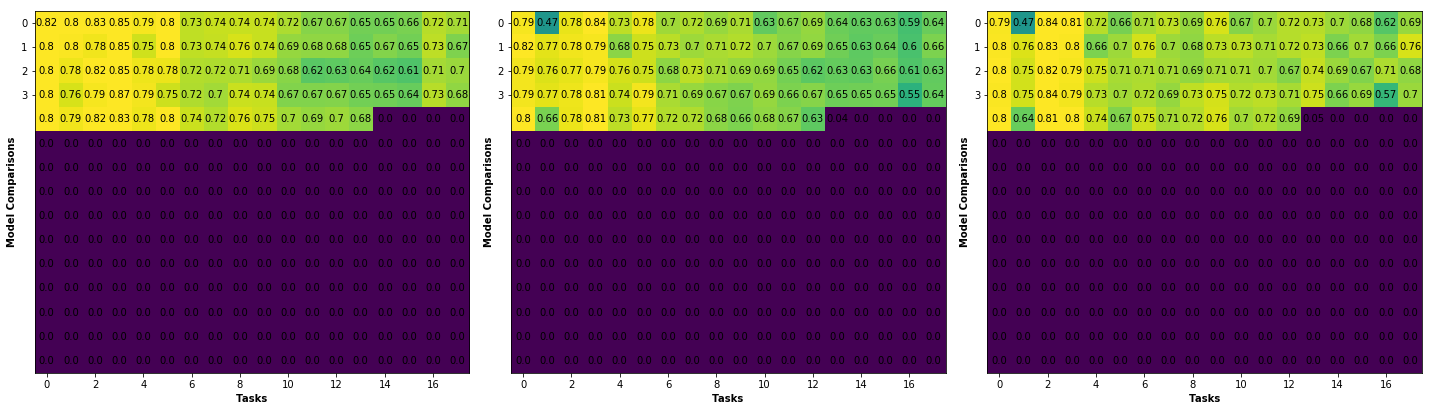

In [28]:
# between all and all

corrmat = cancorrs_aa
FIG_WIDTH = 20 # inches
FIG_HEIGHT = 15 # inches
FONT_WEIGHT = 'bold'
fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT),tight_layout=True)
ax = fig.add_subplot(131)
ax.set_xlabel('Tasks', fontweight=FONT_WEIGHT)
ax.set_ylabel('Model Comparisons', fontweight=FONT_WEIGHT)
ax.imshow(corrmat, clim=(0.1, .8))
ax.set_yticks(range(0,n))
for (j,i),label in np.ndenumerate(corrmat):
    ax.text(i,j,round(label,2),ha='center',va='center')

    # between all and single model
corrmat = cancorrs_as
ax = fig.add_subplot(132)
ax.set_xlabel('Tasks', fontweight=FONT_WEIGHT)
ax.set_ylabel('Model Comparisons', fontweight=FONT_WEIGHT)
ax.imshow(corrmat, clim=(0.1, .8))
ax.set_yticks(range(0,n))
for (j,i),label in np.ndenumerate(corrmat):
    ax.text(i,j,round(label,2),ha='center',va='center')

    # between single model and single model
corrmat = cancorrs_ss
ax = fig.add_subplot(133)
ax.set_xlabel('Tasks', fontweight=FONT_WEIGHT)
ax.set_ylabel('Model Comparisons', fontweight=FONT_WEIGHT)
ax.imshow(corrmat, clim=(0.1, .8))
ax.set_yticks(range(0,n))
for (j,i),label in np.ndenumerate(corrmat):
    ax.text(i,j,round(label,2),ha='center',va='center')

ValueError: x and y must have same first dimension, but have shapes (90,) and (270,)

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


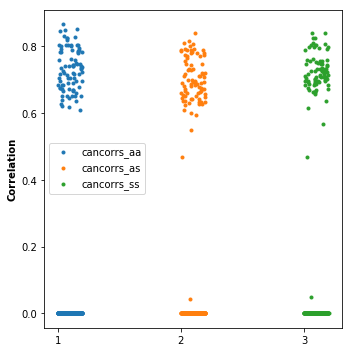

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


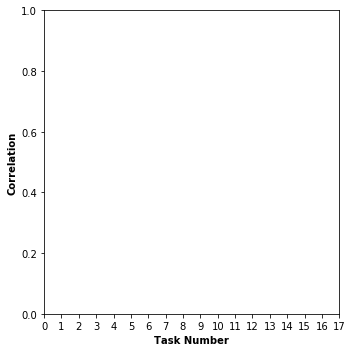

In [29]:
FIG_WIDTH = 5 # inches
FIG_HEIGHT = 5 # inches
FONT_WEIGHT = 'bold'
fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT),tight_layout=True)
ax = fig.add_subplot(111)
ax.set_ylabel('Correlation', fontweight=FONT_WEIGHT)

plt.plot(1+.2*np.random.rand(np.shape(cancorrs_aa.flatten())[0]),cancorrs_aa.flatten(),'.')
plt.plot(2+.2*np.random.rand(np.shape(cancorrs_as.flatten())[0]),cancorrs_as.flatten(),'.')
plt.plot(3+.2*np.random.rand(np.shape(cancorrs_ss.flatten())[0]),cancorrs_ss.flatten(),'.')
ax.set_xticks(range(1,4))
ax.legend(('cancorrs_aa','cancorrs_as','cancorrs_ss'),loc = 'best')

FIG_WIDTH = 5 # inches
FIG_HEIGHT = 5 # inches
FONT_WEIGHT = 'bold'
fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT),tight_layout=True)
ax = fig.add_subplot(111)
ax.set_xticks(range(0,len(task_names)))
ax.set_xlabel('Task Number', fontweight=FONT_WEIGHT)
ax.set_ylabel('Correlation', fontweight=FONT_WEIGHT)

task_mat = np.matlib.repmat(range(0,len(task_names)),1,n+1)
plt.plot(np.squeeze(task_mat)-.1,cancorrs_aa.flatten(),'.')
plt.plot(np.squeeze(task_mat),cancorrs_as.flatten(),'.')
plt.plot(np.squeeze(task_mat)+.1,cancorrs_ss.flatten(),'.')
ax.legend(('cancorrs_aa','cancorrs_as','cancorrs_ss'),loc = 'best')

In [3]:
# Subsets of trial types
n_components = 3
n_models = 5
X = {}
model_path_single = '/home/laura/code/yangnet/training/data/sub_training'
model_path_all = '/home/laura/data/multitask/train_all'
task_names = ['fdgo', 'reactgo', 'fdanti', 'reactanti', 'delayanti','delaygo']#,
              #'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm',
              #'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              #'dmsgo', 'dmsnogo']
    
n_comparisons = int((n_models*(n_models-1))/2)    
prccorrs_aa = np.zeros((n_comparisons,len(task_names)))
prccorrs_as = np.zeros((n_comparisons,len(task_names)))
prccorrs_ss = np.zeros((n_comparisons,len(task_names)))
n = -1
for m0 in range(0,n_models):
    model_dir0a = os.path.join(model_path_all, str(m0))  
    
    for m1 in range(m0+1,n_models):
        n += 1
        model_dir1a = os.path.join(model_path_all, str(m1))
    
        for task_trial in range(0,len(task_names)):
            trial_dir = os.path.join(model_path_single, task_names[task_trial], str(0))
            trial = gen_trials_from_model_dir(trial_dir)
                              
            model_dir0s = os.path.join(model_path_single, task_names[task_trial], str(m0))
            model_dir1s = os.path.join(model_path_single, task_names[task_trial], str(m1))

            X0s = load_X_from_model_dir(model_dir0s,trial)
            X1s = load_X_from_model_dir(model_dir1s,trial)
            train0s, test0s = CCA_prep(X0s,n_components)
            train1s, test1s = CCA_prep(X1s,n_components)
            
            X0a = load_X_from_model_dir(model_dir0a,trial)
            X1a = load_X_from_model_dir(model_dir1a,trial)
            train0a, test0a = CCA_prep(X0a,n_components)
            train1a, test1a = CCA_prep(X1a,n_components)
            
            mtx1aa, mtx2aa, disparity = procrustes(train0a, train1a)
            mtx1as, mtx2as, disparity  = procrustes(train0a, train1s)
            mtx1ss, mtx2ss, disparity  = procrustes(train0s, train1s)
            
            
            temp_aa = np.zeros(n_components)
            temp_as = np.zeros(n_components)
            temp_ss = np.zeros(n_components)
            
            if np.array_equal(mtx1ss,mtx2ss):
                raise ValueError('same model!')
            
            for cc in range(0,n_components):
                temp_aa[cc] = np.corrcoef(mtx1aa[:,cc],mtx2aa[:,cc])[0,1]
                temp_as[cc] = np.corrcoef(mtx1as[:,cc],mtx2as[:,cc])[0,1]
                temp_ss[cc] = np.corrcoef(mtx1ss[:,cc],mtx2ss[:,cc])[0,1]
                            
            prccorrs_aa[n,task_trial] = np.mean(temp_aa)
            prccorrs_as[n,task_trial] = np.mean(temp_as)
            prccorrs_ss[n,task_trial] = np.mean(temp_ss)

INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/fdgo/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/fdgo/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/fdgo/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/fdgo/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/fdgo/1/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/fdgo/1/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/0/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/1/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/1/model.ckpt
INFO:tensorflow:Restoring parameters fro

INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/fdanti/2/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/fdanti/2/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/0/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/2/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/2/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/reactanti/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/reactanti/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/reactanti/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/reactanti/0/model.ckpt
INFO:tensorflow:

INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/3/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/3/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/delaygo/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/delaygo/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/delaygo/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/delaygo/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/delaygo/3/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/delaygo/3/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/0/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/0/model.ckpt
INFO:tensorflow:Restor

Model restored from file: /home/laura/code/yangnet/training/data/sub_training/reactgo/1/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/reactgo/2/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/reactgo/2/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/1/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/1/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/2/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/2/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/fdanti/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/fdanti/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/fdanti/1/model.ckpt
Model restored from file:

Model restored from file: /home/laura/data/multitask/train_all/1/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/3/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/3/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/delayanti/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/delayanti/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/delayanti/1/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/delayanti/1/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/delayanti/3/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/delayanti/3/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/1/model.ckpt
Model rest

INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/fdgo/2/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/fdgo/2/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/fdgo/3/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/fdgo/3/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/2/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/2/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/3/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/3/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/reactgo/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/reactgo/0/model.ckpt
INFO:tensorflow:Restoring paramete

INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/2/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/2/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/4/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/4/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/reactanti/0/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/reactanti/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/reactanti/2/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/reactanti/2/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/reactanti/4/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/reactanti/4/model.ckpt
INFO:tenso

Model restored from file: /home/laura/code/yangnet/training/data/sub_training/delaygo/0/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/delaygo/3/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/delaygo/3/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/code/yangnet/training/data/sub_training/delaygo/4/model.ckpt
Model restored from file: /home/laura/code/yangnet/training/data/sub_training/delaygo/4/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/3/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/3/model.ckpt
INFO:tensorflow:Restoring parameters from /home/laura/data/multitask/train_all/4/model.ckpt
Model restored from file: /home/laura/data/multitask/train_all/4/model.ckpt


/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


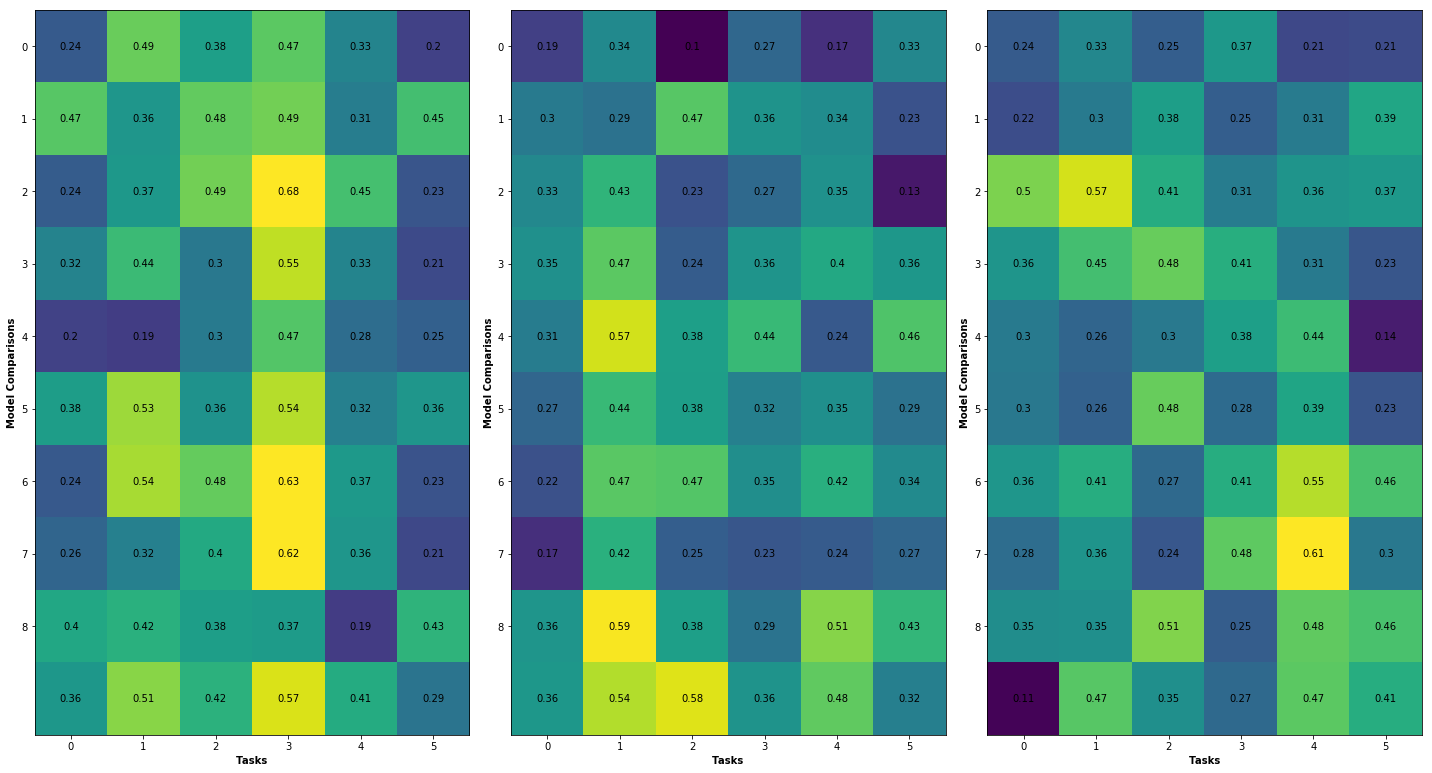

In [10]:
# between all and all

corrmat = prccorrs_aa
FIG_WIDTH = 20 # inches
FIG_HEIGHT = 15 # inches
FONT_WEIGHT = 'bold'
fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT),tight_layout=True)
ax = fig.add_subplot(131)
ax.set_xlabel('Tasks', fontweight=FONT_WEIGHT)
ax.set_ylabel('Model Comparisons', fontweight=FONT_WEIGHT)
ax.imshow(corrmat, clim=(0.1, .6))
ax.set_yticks(range(0,n))
for (j,i),label in np.ndenumerate(corrmat):
    ax.text(i,j,round(label,2),ha='center',va='center')

    # between all and single model
corrmat = prccorrs_as
ax = fig.add_subplot(132)
ax.set_xlabel('Tasks', fontweight=FONT_WEIGHT)
ax.set_ylabel('Model Comparisons', fontweight=FONT_WEIGHT)
ax.imshow(corrmat, clim=(0.1, .6))
ax.set_yticks(range(0,n))
for (j,i),label in np.ndenumerate(corrmat):
    ax.text(i,j,round(label,2),ha='center',va='center')

    # between single model and single model
corrmat = prccorrs_ss
ax = fig.add_subplot(133)
ax.set_xlabel('Tasks', fontweight=FONT_WEIGHT)
ax.set_ylabel('Model Comparisons', fontweight=FONT_WEIGHT)
ax.imshow(corrmat, clim=(0.1, .6))
ax.set_yticks(range(0,n))
for (j,i),label in np.ndenumerate(corrmat):
    ax.text(i,j,round(label,2),ha='center',va='center')

/home/laura/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


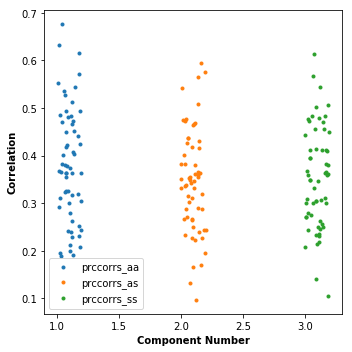

In [8]:
FIG_WIDTH = 5 # inches
FIG_HEIGHT = 5 # inches
FONT_WEIGHT = 'bold'
fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT),tight_layout=True)
ax = fig.add_subplot(111)
ax.set_xlabel('Component Number', fontweight=FONT_WEIGHT)
ax.set_ylabel('Correlation', fontweight=FONT_WEIGHT)
plt.plot(1+.2*np.random.rand(np.shape(prccorrs_aa.flatten())[0]),prccorrs_aa.flatten(),'.')
plt.plot(2+.2*np.random.rand(np.shape(prccorrs_as.flatten())[0]),prccorrs_as.flatten(),'.')
plt.plot(3+.2*np.random.rand(np.shape(prccorrs_ss.flatten())[0]),prccorrs_ss.flatten(),'.')
ax.legend(('prccorrs_aa','prccorrs_as','prccorrs_ss'))

In [27]:
print(np.shape(temp_aa))

(3,)
